In [116]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV





pio.renderers.default = "browser"

In [24]:
fp1 = '../data/league_2021.csv'
fp2 = '../data/league_2022.csv'
fp3 = '../data/league_2023.csv'
fp4 = '../data/league_2024.csv'

leeg21 = pd.read_csv(fp1)
leeg22 = pd.read_csv(fp2)
leeg23 = pd.read_csv(fp3)
leeg24 = pd.read_csv(fp4)

league = pd.concat([leeg21, leeg22, leeg23, leeg24])
league.head()

/Users/joycehu/miniforge3/envs/dsc80/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,118.0,748.0,-56.0,-4.0,2.0,0.0,1.0,0.0,1.0,1.0
1,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,84.0,2120.0,3405.0,62.0,3.0,2.0,0.0,2.0,0.0,3.0
2,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,143.0,1578.0,354.0,15.0,2.0,3.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,120.0,124.0,102.0,10.0,0.0,4.0,2.0,1.0,1.0,2.0
4,ESPORTSTMNT03/1632489,complete,http://matchhistory.na.leagueoflegends.com/en/...,KeSPA,2021,NaN,0,2021-01-02 07:40:39,1.0,10.25,...,25.0,448.0,450.0,3.0,1.0,4.0,0.0,0.0,2.0,2.0


In [ ]:
league['']

# Data Cleaning

In [42]:
# make copy 
pre_cleaning = league.copy()

# binary variable for missing patch
league['patch_missing'] = (league['patch'].isna()).astype(int)

## impute missing patches
patches = {
    '2022-08-11 08:37:33':12.15, 
    '2022-08-12 06:08:39':12.15, 
    '2022-08-12 07:04:40':12.15, 
    '2022-08-12 07:52:33':12.15, 
    '2022-08-12 08:51:49':12.15, 
    '2022-08-12 09:58:13':12.15, 
    '2022-08-13 06:08:31':12.15, 
    '2022-08-13 06:55:35':12.15, 
    '2022-08-13 06:08:31':12.15,
    '2022-08-13 06:55:35':12.15,
    '2022-08-13 07:47:42':12.15,
    '2023-04-05 09:17:28':13.07,
    '2023-04-05 10:18:03':13.07, 
    '2023-04-05 11:23:10':13.07,
    '2023-04-05 12:21:13':13.07,
    '2023-04-05 13:10:18':13.07,
    '2023-05-08 06:12:19':13.09,
    '2023-05-08 07:07:13':13.09,
    '2023-05-08 08:12:21':13.09,
    '2023-05-08 09:06:19':13.09,
    '2023-05-08 10:08:36':13.09,
    '2024-02-21 06:02:57':14.03,
    '2024-02-21 06:56:52':14.03, 
    '2024-02-21 07:43:27':14.03,
    '2024-02-21 08:31:33':14.03, 
    '2024-02-21 09:17:02':14.03
}
league['patch'] = league['patch'].fillna(league['date'])
league['patch'] = league['patch'].replace(patches)

## impute team statistics into missing player level stats for 'firstdragon', 'firstherald', 'heralds', 'opp_heralds'

# get team summary statistics 
team_stats = (league[(league['participantid'] == 100) | (league['participantid'] == 200)]
              .loc[:,['gameid', 'teamid','firstdragon', 'firstherald', 'heralds', 'opp_heralds']])

# subset dataframe to player level data
league = league[(league['participantid'] != 100) & (league['participantid'] != 200)]

# drop stats cols in league to retain col names after merge
league = league.drop(columns=['firstdragon', 'firstherald', 'heralds', 'opp_heralds'])

# merge team stats onto player level data
league = league.merge(team_stats, on=['gameid', 'teamid'], how='left')

# create a binary variable for before and after Patch 13.9
league['post_rework'] = (league['patch'] >= 13.09).astype(int)

# create a binary variable for whether neeko played in the game
league['neeko'] = (league['champion'] == 'Neeko').astype(int)

# create a new variable for difference in heralds gained 
league['herald_diff'] = league['heralds'] - league['opp_heralds']

# keep features we need
league = (league.loc[:, ['gameid', 'teamid', 'neeko', 'position', 'datacompleteness','league', 
                'patch', 'firstdragon', 'firstherald', 'herald_diff', 'goldat15','xpat15','csat15',
                'golddiffat15','xpdiffat15','csdiffat15','killsat15','assistsat15','deathsat15',
                'result']])

league.head()

,gameid,teamid,neeko,position,datacompleteness,league,patch,firstdragon,firstherald,herald_diff,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,result
0,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,top,complete,KeSPA,10.25,1.0,1.0,2.0,5407.0,7536.0,114.0,748.0,-56.0,-4.0,2.0,0.0,1.0,1
1,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,jng,complete,KeSPA,10.25,1.0,1.0,2.0,6974.0,8232.0,146.0,2120.0,3405.0,62.0,3.0,2.0,0.0,1
2,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,mid,complete,KeSPA,10.25,1.0,1.0,2.0,6591.0,7827.0,158.0,1578.0,354.0,15.0,2.0,3.0,0.0,1
3,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,bot,complete,KeSPA,10.25,1.0,1.0,2.0,5202.0,5053.0,130.0,124.0,102.0,10.0,0.0,4.0,2.0,1
4,ESPORTSTMNT03/1632489,oe:team:2e79800a550f87f2378dbba9368396d,0,sup,complete,KeSPA,10.25,1.0,1.0,2.0,3853.0,4681.0,28.0,448.0,450.0,3.0,1.0,4.0,0.0,1


# Missingness

### League

In [290]:
piv = league.pivot_table(index='league', columns='patch_missing', aggfunc='size').fillna(0)
piv

piv = piv / piv.sum()
piv.head()

patch_missing,0,1
league,,
AL,0.011189,0.0
CBLOL,0.022834,0.0
CBLOLA,0.021771,0.0
CDF,0.007139,0.0
CT,0.003493,0.0


In [281]:
# calculate observed tvd
obs = piv.diff(axis=1).iloc[:,-1].abs().sum() / 2
obs

0.8501300011641896

In [301]:
n_repetitions = 500
shuffled = league[['league', 'patch_missing']]

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether patch is missing
    shuffled['shuffle_patch'] = np.random.permutation(shuffled['patch_missing'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='league', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

/var/folders/p3/nfh6l6hn58q316g9ty88_q9r0000gn/T/ipykernel_518/4193713791.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[0.16805689163417886,
 0.19498801748434677,
 0.16176923531297993,
 0.152103058073009,
 0.17034686007459537,
 0.17335092737920443,
 0.15111998548596695,
 0.15874196243228195,
 0.1722729228899803,
 0.1802841206352421]

In [302]:
(np.array(tvds) >= obs).mean()

0.0

### result

In [321]:
piv = league.pivot_table(index='result', columns='patch_missing', aggfunc='size').fillna(0)
piv

piv = piv / piv.sum()
piv

patch_missing,0,1
result,,
0,0.500101,0.5
1,0.499899,0.5


In [322]:
obs = piv.diff(axis=1).iloc[:,-1].abs().sum() / 2
obs

0.00010126069566096518

In [325]:
n_repetitions = 500
shuffled = league[['result', 'patch_missing']]

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether patch is missing
    shuffled['shuffle_patch'] = np.random.permutation(shuffled['patch_missing'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='result', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

/var/folders/p3/nfh6l6hn58q316g9ty88_q9r0000gn/T/ipykernel_518/2255443645.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[0.037646828008708416,
 0.06267720621740669,
 0.07102066562030612,
 0.0334750983072587,
 0.029303368605808983,
 0.029303368605808983,
 0.016788179501459888,
 0.037646828008708416,
 0.004272990397110682,
 0.041616036318836175]

In [326]:
(np.array(tvds) >= obs).mean()

1.0

### Permutation Test:

Is there a higher proportion of games with a Neeko in it after the Patch 13.9 rework?

Null: There is no difference in proportion of games with Neeko before and after the Patch 13.9 rework.


Alternative: There is a higher proportion of games with Neeko after the Patch 13.9 rework. 


Test Statistic: Difference in Proportion


Significance Level: 0.05


Result p-value:


In [262]:
# create a new df where each observation is a game (game id becomes unique)
rework = league.groupby('gameid').agg({'post_rework': 'first', 'neeko':'sum'})
rework

,post_rework,neeko
gameid,,
10000-10000_game_1,0,0
10000-10000_game_2,0,0
10000-10000_game_3,0,0
10000-10000_game_4,0,0
10000-10000_game_5,0,0
...,...,...
NA1_4493482900,0,0
NA1_4493540863,0,0
NA1_4493591166,0,0


In [263]:
# observed value is the proportion of games with neeko after - before the patch
obs = rework.groupby('post_rework').mean().diff().iloc[-1][0]
obs

0.1409457061646073

In [260]:
n_reps = 10_000
diffs = []

for _ in range(n_reps):
    
    # shuffle rework column 
    rework['shuffled_rework'] = np.random.permutation(rework['post_rework'])
    
    # compute test statistic 
    difference = rework.groupby('shuffled_rework').mean().diff().iloc[-1][0]
    
    diffs.append(difference)

diffs[:10]

[0.009599453189624352,
 -0.0030056446788713775,
 0.0027566857752980845,
 0.005817923829075589,
 -0.009668339266504788,
 0.000955957508370131,
 -0.014530305587210246,
 -0.005886809905956081,
 -0.009308193613119242,
 -0.00876797513304084]

In [261]:
# calculate p-value
(np.array(diffs) >= obs).mean()

0.0

### code that isn't important for this: 

In [21]:
by_patch = players['patch'].value_counts().to_frame().reset_index().sort_values('index')
by_patch.head()

,index,patch
13,12.01,8020
7,12.02,9680
11,12.03,8770
2,12.04,13240
3,12.05,12450


In [63]:
by_patch[(by_patch['index'] < 13.09) & (by_patch['index'] >= 12.10)]['patch'].sum() / 10

11669.0

In [64]:
by_patch[by_patch['index'] > 13.09]['patch'].sum() / 10

7420.0

In [65]:
11669 - 7420.0

4249.0

In [6]:
for col in league.columns:
    print(col)

gameid
datacompleteness
url
league
year
split
playoffs
date
game
patch
participantid
side
position
playername
playerid
teamname
teamid
champion
ban1
ban2
ban3
ban4
ban5
pick1
pick2
pick3
pick4
pick5
gamelength
result
kills
deaths
assists
teamkills
teamdeaths
doublekills
triplekills
quadrakills
pentakills
firstblood
firstbloodkill
firstbloodassist
firstbloodvictim
team kpm
ckpm
firstdragon
dragons
opp_dragons
elementaldrakes
opp_elementaldrakes
infernals
mountains
clouds
oceans
chemtechs
hextechs
dragons (type unknown)
elders
opp_elders
firstherald
heralds
opp_heralds
void_grubs
opp_void_grubs
firstbaron
barons
opp_barons
firsttower
towers
opp_towers
firstmidtower
firsttothreetowers
turretplates
opp_turretplates
inhibitors
opp_inhibitors
damagetochampions
dpm
damageshare
damagetakenperminute
damagemitigatedperminute
wardsplaced
wpm
wardskilled
wcpm
controlwardsbought
visionscore
vspm
totalgold
earnedgold
earned gpm
earnedgoldshare
goldspent
gspd
gpr
total cs
minionkills
monsterkills
mon

In [7]:
league[league['gameid'] == 'ESPORTSTMNT01_2690210']['participantid']

0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10    100
11    200
Name: participantid, dtype: int64

# Prediction 

Predict whether Neeko's team wins the game based on her stats at 15 minutes and her position (ohe).

We will include 2021 data because Neeko doesn't change much between seasons.

Time of prediction is 15 min into the game

Utility: should we ff or not

In [47]:
# include 2021 data 
neeko = league[league['neeko']==1]
# get rid of partial
neeko = neeko[(neeko['datacompleteness']=='complete') & (neeko['patch'] >= 11.07)]
neeko.head()

,gameid,teamid,neeko,position,datacompleteness,league,patch,firstdragon,firstherald,herald_diff,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,result
50657,NA1/3859085355,oe:team:4fe384f3e93db8f9a984f06a3c75e6c,1,mid,complete,UPL,11.07,0.0,0.0,-2.0,5591.0,7161.0,112.0,-2179.0,-1110.0,-35.0,2.0,1.0,3.0,0
57517,ESPORTSTMNT01/2002464,oe:team:65140c73015d004b0456fb43ba373a4,1,mid,complete,LMF,11.10,1.0,0.0,-2.0,4993.0,6751.0,118.0,-807.0,-571.0,7.0,1.0,0.0,1.0,0
57722,NA1/3916799284,oe:team:9548eb0ae58f318888c036712da329b,1,mid,complete,CU,11.10,0.0,1.0,0.0,5233.0,7486.0,140.0,-781.0,634.0,12.0,1.0,0.0,1.0,0
59177,NA1/3927500028,oe:team:47b7394e386b2ab9bb97100fe136098,1,mid,complete,CU,11.11,1.0,1.0,0.0,5189.0,7829.0,149.0,-169.0,35.0,-1.0,0.0,0.0,0.0,0
137267,ESPORTSTMNT02_2557639,oe:team:1ab54595dac94e054c4f3831f7ccb98,1,mid,complete,EL,12.02,1.0,1.0,2.0,5689.0,7053.0,129.0,381.0,97.0,3.0,1.0,3.0,0.0,1


In [59]:
neeko['result'].value_counts(normalize=True)

1    0.528587
0    0.471413
Name: result, dtype: float64

### Setting up data

In [142]:
variables = ['position', 'patch', 'firstdragon', 'firstherald', 'herald_diff', 'goldat15',
       'xpat15', 'csat15', 'golddiffat15', 'xpdiffat15', 'csdiffat15',
       'killsat15', 'assistsat15', 'deathsat15']
features = neeko.loc[:, variables] 
target = neeko['result']  

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=12)

### Baseline Model

In [149]:
# feature engineering 
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['position']),
    ('passthrough', 'passthrough', ['goldat15','xpat15','csat15','killsat15','assistsat15','deathsat15'])
], remainder='drop')

pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', LogisticRegression(max_iter = 10000))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
print("Train set accuracy:", pipeline.score(X_train, y_train))
print("Test set accuracy:", pipeline.score(X_test, y_test))

Train set accuracy: 0.6491228070175439
Test set accuracy: 0.6612903225806451


The train set and test set accuracies are both low but they are about the same, so there is at least no risk of overfitting. We will add more features and do some feature engineering to see if we can improve the model.

In [148]:
# feature engineering
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), ['position']),
    ('binarize', Binarizer(), ['golddiffat15','xpdiffat15','csdiffat15']),
    ('standard', StandardScaler(), stats_15 + ['herald_diff'])
], remainder='passthrough')

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', LogisticRegression(max_iter = 10000))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
print("Train set accuracy:", pipeline.score(X_train, y_train))
print("Test set accuracy:", pipeline.score(X_test, y_test))

Train set accuracy: 0.6828609986504723
Test set accuracy: 0.6935483870967742


The accuracy is still low, so we will look for the best threshold for our model.

In [150]:
thresholds = np.arange(0.01, 1.01, 0.01)
precisions = np.array([])
recalls = np.array([])

for t in thresholds:
    y_pred = pipeline.predict_proba(X_test)[:, 1] >= t
    precisions = np.append(precisions, metrics.precision_score(y_test, y_pred, zero_division=1))
    recalls = np.append(recalls, metrics.recall_score(y_test, y_pred))

In [64]:
px.line(x=recalls, y=precisions, hover_name=thresholds, 
        labels={'x': 'Recall', 'y': 'Precision'}, title='Precision vs. Recall')

In [175]:
pipeline = Pipeline([
    ('preprocessor', ct),
    ('classifier', LogisticRegression(max_iter = 10000))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

best_threshold = 0.50

y_pred_train = pipeline.predict_proba(X_train)[:, 1] >= best_threshold
y_pred_test = pipeline.predict_proba(X_test)[:, 1] >= best_threshold

# Evaluate the pipeline
print("Train set accuracy:", metrics.accuracy_score(y_train, y_pred_train))
print("Test set accuracy:", metrics.accuracy_score(y_test, y_pred_test))

Train set accuracy: 0.6491228070175439
Test set accuracy: 0.6612903225806451


0.5 is still the best.

Trying other models:

In [180]:
pipeline = Pipeline([
    ('preprocessor', ct),
    ('random-forest', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

print("Train set accuracy:", pipeline.score(X_train, y_train))
print("Test set accuracy:", pipeline.score(X_test, y_test))

Train set accuracy: 1.0
Test set accuracy: 0.6881720430107527


In [ ]:
hyperparameters = {
    'max_depth': [2, 3, 4, 5, 7, 10, 13, 15, 18, None], 
    'min_samples_split': [2, 5, 10, 20, 50, 100, 200],
    'criterion': ['gini', 'entropy']
}

In [227]:
hyperparameters = {
    'random-forest__min_samples_split': [2, 5, 10, 20, 30, 40, 50, 100],
    'random-forest__max_depth': np.arange(2, 200, 20),
    'random-forest__criterion': ['gini', 'entropy']
}

ct = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), ['position']),
    ('standard', StandardScaler(), stats_15 + ['herald_diff'])
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', ct),
    ('random-forest', RandomForestClassifier(random_state=12))
])

grids = GridSearchCV(
    pipeline,
    n_jobs=-1, # Use multiple processors to parallelize.
    param_grid=hyperparameters,
    return_train_score=True, 
    cv=5
)
grids.fit(X_train, y_train)

# Evaluate the pipeline
print("Train set accuracy:", grids.score(X_train, y_train))
print("Test set accuracy:", grids.score(X_test, y_test))


Train set accuracy: 0.8286099865047234
Test set accuracy: 0.7204301075268817


In [228]:
grids.best_params_

{'random-forest__criterion': 'gini',
 'random-forest__max_depth': 22,
 'random-forest__min_samples_split': 30}

# Fairness Analysis

Null Hypothesis: Our model is fair. Its accuracy for Tier 1 leagues and non-Tier 1 leagues are roughly the same, and any differences are due to random chance.  
Alternative Hypothesis: Our model is unfair. Its accuracy for non-Tier 1 leagues are lower than its accuracy for Tier 1 leagues.  

In [219]:
t1 = ['LCK', 'LPL', 'LEC', 'LCS', 'PCS', 'VCS', 'CBLOL', 'LLA']
neeko['tier1'] = (neeko['league'].isin(t1)).astype(int)

In [244]:
fair = neeko.loc[:,['tier1', 'result'] + variables]
fair.head()

,tier1,result,position,patch,firstdragon,firstherald,herald_diff,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15
50657,0,0,mid,11.07,0.0,0.0,-2.0,5591.0,7161.0,112.0,-2179.0,-1110.0,-35.0,2.0,1.0,3.0
57517,0,0,mid,11.10,1.0,0.0,-2.0,4993.0,6751.0,118.0,-807.0,-571.0,7.0,1.0,0.0,1.0
57722,0,0,mid,11.10,0.0,1.0,0.0,5233.0,7486.0,140.0,-781.0,634.0,12.0,1.0,0.0,1.0
59177,0,0,mid,11.11,1.0,1.0,0.0,5189.0,7829.0,149.0,-169.0,35.0,-1.0,0.0,0.0,0.0
137267,0,1,mid,12.02,1.0,1.0,2.0,5689.0,7053.0,129.0,381.0,97.0,3.0,1.0,3.0,0.0


In [259]:
results = pd.merge(X_test, neeko.loc[:,['tier1']], left_index=True, right_index=True, how='left')
results['prediction'] = grids.predict(X_test)
results['result'] = y_test
results.head()

,position,patch,firstdragon,firstherald,herald_diff,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,tier1,prediction,result
377347,mid,14.04,1.0,1.0,1.0,5315.0,7311.0,131.0,110.0,-65.0,-12.0,1.0,1.0,0.0,0,1,1
362047,mid,14.02,1.0,1.0,1.0,5548.0,7687.0,142.0,175.0,15.0,2.0,1.0,0.0,1.0,1,1,0
310952,mid,13.11,0.0,1.0,0.0,4991.0,7258.0,130.0,-122.0,-784.0,-23.0,0.0,1.0,0.0,0,0,1
310561,jng,13.11,1.0,1.0,2.0,6300.0,6866.0,120.0,1655.0,1392.0,28.0,2.0,4.0,0.0,1,1,1
375977,mid,14.04,1.0,0.0,-1.0,4947.0,7801.0,135.0,240.0,871.0,7.0,0.0,1.0,0.0,0,1,1


demographic parity? the two look similar!

In [260]:
results.groupby('tier1')['prediction'].mean()

tier1
0    0.511278
1    0.603774
Name: prediction, dtype: float64

accuracy also looks similar!

In [262]:
compute_accuracy = lambda x: metrics.accuracy_score(x['result'], x['prediction'])
(
    results
    .groupby('tier1')
    .apply(compute_accuracy)
    .rename('accuracy')
)

tier1
0    0.736842
1    0.679245
Name: accuracy, dtype: float64

In [264]:
obs = results.groupby('tier1').apply(compute_accuracy).diff().iloc[-1]
obs

-0.05759682224428997

In [265]:
diff_in_acc = []
for _ in range(500):
    s = (
        results[['tier1', 'prediction', 'result']]
        .assign(is_young=np.random.permutation(results['tier1']))
        .groupby('tier1')
        .apply(compute_accuracy)
        .diff()
        .iloc[-1]
    )
    
    diff_in_acc.append(s)

In [267]:
(np.array(diff_in_acc) >= obs).mean()

1.0

AttributeError: 'Rectangle' object has no property 'histnorm'

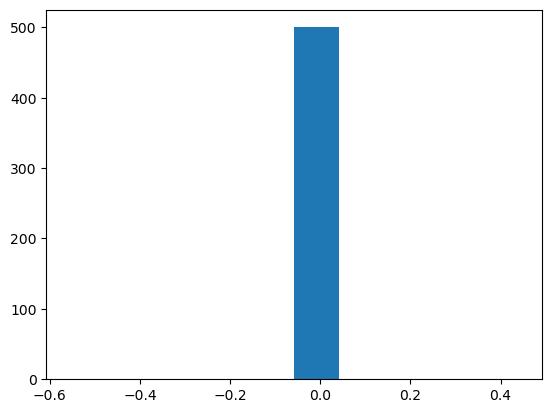

In [268]:
fig = pd.Series(diff_in_acc).plot(kind='hist', histnorm='probability', nbins=20,
                            title='Difference in Accuracy for Tier 1 vs Non-Tier 1 Leagues')
fig.add_vline(x=obs, line_color='red')
fig.update_layout(xaxis_range=[-0.1, 0.05])

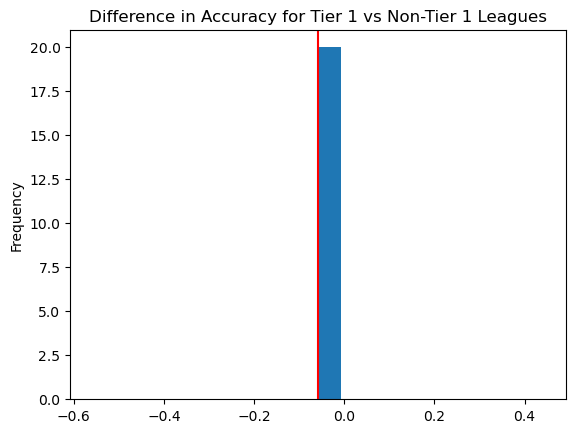

In [274]:
fig = pd.Series(diff_in_acc).plot(kind='hist', density=True, bins=20,
                        title='Difference in Accuracy for Tier 1 vs Non-Tier 1 Leagues')
fig.axvline(x=obs, color='red')

In [247]:
t1_df = fair[fair['tier1'] == 1].drop(columns='tier1')
X_t1 = t1_df.drop(columns='result')
y_t1 = t1_df['result']

grids.score(X_t1, y_t1)

0.7936507936507936

In [248]:
non_df = fair[fair['tier1'] == 0].drop(columns='tier1')
X_non = non_df.drop(columns='result')
y_non = non_df['result']

grids.score(X_non, y_non)

0.8118518518518518

In [ ]:
# conduct a permutation test
n_repetitions = 500
shuffled = fair.copy()

tvds = []
for _ in range(n_repetitions):
    
    # shuffle whether the team is tier 1
    shuffled['shuffle_tier1'] = np.random.permutation(shuffled['tier1'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled.pivot_table
        (index='result', columns='shuffle_patch', aggfunc='size').fillna(0)
    )
    
    pivoted = pivoted / pivoted.sum()
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)
tvds[:10]

In [220]:
neeko

,gameid,teamid,neeko,position,datacompleteness,league,patch,firstdragon,firstherald,herald_diff,...,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,result,tier1
50657,NA1/3859085355,oe:team:4fe384f3e93db8f9a984f06a3c75e6c,1,mid,complete,UPL,11.07,0.0,0.0,-2.0,...,7161.0,112.0,-2179.0,-1110.0,-35.0,2.0,1.0,3.0,0,0
57517,ESPORTSTMNT01/2002464,oe:team:65140c73015d004b0456fb43ba373a4,1,mid,complete,LMF,11.10,1.0,0.0,-2.0,...,6751.0,118.0,-807.0,-571.0,7.0,1.0,0.0,1.0,0,0
57722,NA1/3916799284,oe:team:9548eb0ae58f318888c036712da329b,1,mid,complete,CU,11.10,0.0,1.0,0.0,...,7486.0,140.0,-781.0,634.0,12.0,1.0,0.0,1.0,0,0
59177,NA1/3927500028,oe:team:47b7394e386b2ab9bb97100fe136098,1,mid,complete,CU,11.11,1.0,1.0,0.0,...,7829.0,149.0,-169.0,35.0,-1.0,0.0,0.0,0.0,0,0
137267,ESPORTSTMNT02_2557639,oe:team:1ab54595dac94e054c4f3831f7ccb98,1,mid,complete,EL,12.02,1.0,1.0,2.0,...,7053.0,129.0,381.0,97.0,3.0,1.0,3.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382247,LOLTMNT04_31805,oe:team:1285e1c04d54de96502f12da4d49458,1,mid,complete,LEC,14.05,0.0,0.0,-1.0,...,7293.0,129.0,-305.0,-770.0,-13.0,0.0,0.0,0.0,1,1
382257,LOLTMNT01_70626,oe:team:c288aa1a7bae5494d7ba97a65e28378,1,mid,complete,NEXO,14.05,0.0,0.0,-1.0,...,6917.0,111.0,-474.0,-67.0,-16.0,1.0,0.0,2.0,1,0
382272,LOLTMNT01_71061,oe:team:8eb9a212591f919a353abfac0c0a52a,1,mid,complete,NEXO,14.05,0.0,1.0,1.0,...,7494.0,133.0,-107.0,-460.0,-11.0,1.0,0.0,0.0,0,0
382491,LOLTMNT01_71470,oe:team:f33930460c641ba8c7ffe11342c08ef,1,jng,complete,NEXO,14.05,0.0,1.0,1.0,...,6392.0,120.0,845.0,381.0,5.0,3.0,0.0,0.0,1,0
